# PoS tagging and entity extraction

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016-2017 Florian Leitner. All rights reserved.

## Setup

### NLTK

NLTK-based NLP (should require no more additional steps):

In [3]:
from nltk import ne_chunk, pos_tag, word_tokenize as tokenize
from nltk.stem.snowball import EnglishStemmer
import nltk

### Stanford CoreNLP Taggers

Some of the Stanford [CoreNLP](https://stanfordnlp.github.io/CoreNLP/index.html) tools have wrappers provided by NLTK (Note: and therefore, this part assumes/requires you have **Java** installed on your machine!):

Using those taggers via NLTK requires that you download the (_basic_) Stanford [PoS tagger](http://nlp.stanford.edu/software/tagger.shtml#Download) and [NER tagger](http://nlp.stanford.edu/software/CRF-NER.shtml#Download) ZIP packages, and put the following files from those two packages into a directory named "`stanford`" that itself should be located in the same directory as this notebook; If you cloned the tutorial from its repo, you already have the relevant directory and files in place.

From the NER tagger archive, you need these two files:

* `stanford-ner.jar`
* `english.all.3class.distsim.crf.ser.gz`

And from the PoS tagger:

* `english-bidirectional-distsim.tagger`
* `stanford-postagger.jar`

Add the *full path* to the directories containing `stanford-postagger.jar` and `stanford-ner.jar` to your `CLASSPATH` environment variable and set a `STANFORD_MODELS` en environment variable pointing to the *full path* of this `stanford` directory itself. Make sure you launch the Jupyter Notebook command `jupyter-notebook` in the terminal you set those two environment variables.

```bash
export STANFORD_MODELS=`pwd`/stanford
export CLASSPATH=$STANFORD_MODELS/stanford-ner.jar:$STANFORD_MODELS/stanford-postagger.jar
```

If you get stuck, follow the [full installation instructions](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser) from the NLTK Wiki.

### SpaCy

The SpaCy NLP tool ([installation instructions](https://spacy.io/docs/usage/#installation) - [compressed form](https://spacy.io/docs/usage/lightning-tour)):

In [4]:
import spacy

## Introduction

In this class, we will explore Python-based means to apply the sequence tagging and chunking techniques discussed in class, namely part-of-speech tagging, named entity recognition (NER), and phrase chunking.

Note that NER is the hardest topic of what we will be looking into today, not the least to the extremely broad range of entity types: e.g., corporations, persons, locations & geo-political entities [GPEs], consumer products, genes & proteins, chemicals, etc. - to name just a very small selection of the more popular entity types in NLP.

A more in-depth introduction to most of what we are doing here - PoS tagging, chunking, NER - is well documented in the NLTK Book, [Chapter 7](http://www.nltk.org/book/ch07.html), which you might want to have study in depth if you want to get more serious with NLP in general.

## Tagging, Chunking, and NER with NLTK (w/o CoreNLP)

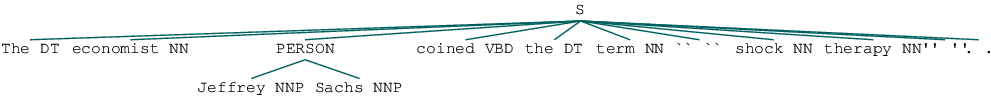

In [3]:
def tagger_nltk(sentence):
    return ne_chunk(pos_tag(tokenize(sentence)))

tagger_nltk('The economist Jeffrey Sachs coined the term "shock therapy".')

A more terminal-friendly tree-view using parenthesis:

In [4]:
tagger_nltk('The economist Jeffrey Sachs coined the term "shock therapy".').pprint()

(S
  The/DT
  economist/NN
  (PERSON Jeffrey/NNP Sachs/NNP)
  coined/VBD
  the/DT
  term/NN
  ``/``
  shock/NN
  therapy/NN
  ''/''
  ./.)


In [5]:
tagger_nltk("The Google Nexus challenges the iPhone's dominance.").pprint()

(S
  The/DT
  (ORGANIZATION Google/NNP Nexus/NNP)
  challenges/VBZ
  the/DT
  (ORGANIZATION iPhone/NN)
  's/POS
  dominance/NN
  ./.)


Note some first errors: "Google Nexus" and "iPhone" are not organizations. In general, in my personal opinion, NER entity taggers are pretty good at detecting named entities - but once you want to separate out entity types at some high level of precision (90, 95, 99, ... % -- not to mention recall issues) on arbitrary input texts, you will start to see that even the best NER tools (say, Bi-LSTM neural networks with a final CRF layer) around today still make silly mistakes a human would not.

In general, my advice is: Use NER to detect all potential named entity mention (of all types - organization, persons, locations, etc.) and then work out your own expert system for the entities you need, instead of hoping that your tagger fully learns the differences between the types. Or, if you are just in need of one entity type, you can train or use an existing model just for that entity types. But even then, I strongly advise to use post-processing of the entity detections with an expert dictionary of all valid names. At the very least, you should verify their plausiblity, like checking persons against a vast collection of names, or checking if that chemical fomula you detected as chemical would even just make sense.

As to NLTK's "default", on-board tagging functionality via `ne_chunk( pos_tag( word_tokenize( sentence )))`, that certainly provides good-enough out-of-the-box results to play around with and make experiments/prototypes and blog posts, but if you need to provide high-quality results for some commericial or scientific application, you will very quickly be "wanting more".

Therefore, here we will take a look at the [Stanford NER Tagger](http://nlp.stanford.edu/software/CRF-NER.shtml) and its [PoS Tagger](http://nlp.stanford.edu/software/tagger.shtml) with ready-made, trained models. Second, we will look at [SpaCy](https://spacy.io/), a  high-throughput NLP tool for Python that is similarly useful and performant as the Stanford Parser. The biggest difference between the two is maybe support for Chinese, Arabic, and French. To date (2017ish), SpaCy "only" supports English, German, and Spanish - but with the promise of more coming. Another significant difference are licenses: CoreNLP comes with the GPL, unless you pay Stanford for a closed-source license, while SpaCy operates under the Apache 2 license.

## Stanford PoS and NER Tagging with NLTK+CoreNLP

We can quickly access the two Stanford taggers via an API provided from NLTK. Note that this might not necessarily be the way you want to interact with the Stanford (Java) tools in a production setting. However, it is a quick and easy way to get a research prototype up and running.

Let's ensure we have everything set up as needed: The JARs and models in a local subdirectory called `stanford`:

In [6]:
!ls stanford/

english-bidirectional-distsim.tagger
english-bidirectional-distsim.tagger.props
english.all.3class.distsim.crf.ser.gz
english.all.3class.distsim.prop
stanford-ner.jar
stanford-postagger.jar


And the two environment variables set to the **full path** of the `stanford-postagger.jar`, the `stanford-ner.jar`, and the model directory (itself):

In [7]:
import os

print('CLASSPATH =', os.environ['CLASSPATH'])
print('STANFORD_MODELS = ', os.environ['STANFORD_MODELS'])

CLASSPATH = /Users/fnl/Documents/ASDM Course - Text Mining/github/new_notebooks/stanford/stanford-postagger.jar:/Users/fnl/Documents/ASDM Course - Text Mining/github/new_notebooks/stanford/stanford-ner.jar
STANFORD_MODELS =  /Users/fnl/Documents/ASDM Course - Text Mining/github/new_notebooks/stanford


More info ambout the generic Stanford NLTK API can be found in the base class:

In [8]:
from nltk.tag.stanford import StanfordTagger
help(StanfordTagger)

Help on class StanfordTagger in module nltk.tag.stanford:

class StanfordTagger(nltk.tag.api.TaggerI)
 |  An interface to Stanford taggers. Subclasses must define:
 |  
 |  - ``_cmd`` property: A property that returns the command that will be
 |    executed.
 |  - ``_SEPARATOR``: Class constant that represents that character that
 |    is used to separate the tokens from their tags.
 |  - ``_JAR`` file: Class constant that represents the jar file name.
 |  
 |  Method resolution order:
 |      StanfordTagger
 |      nltk.tag.api.TaggerI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_filename, path_to_jar=None, encoding='utf8', verbose=False, java_options='-mx1000m')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  parse_output(self, text, sentences=None)
 |  
 |  tag(self, tokens)
 |      Determine the most appropriate tag sequence for the given
 |      token sequence, and return a corresponding list of tagged
 |     

First, initialize the two taggers:

In [9]:
from nltk.tag.stanford import StanfordNERTagger
from nltk.tag.stanford import StanfordPOSTagger

ner = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')
pos = StanfordPOSTagger('english-bidirectional-distsim.tagger')

Second, let's get us word tokenization and some stemming support from NLTK.

In [10]:
st = EnglishStemmer()

With the NLTK stemmer and tokenizer, we can now set up a nice tagging pipeline: 

In [11]:
def tagger_stanford(sentence):
    tokens = tokenize(sentence)
    stems = map(st.stem, tokens)
    _, tags = zip(*pos.tag(tokens))
    _, entities = zip(*ner.tag(tokens))
    return list(zip(tokens, stems, tags, entities))

In [12]:
def pretty(sentence):
    print("{: >15s} {: <15s} {: <5s} {}\n".format("Token", "Stem", "PoS", "NER"))
    for word in sentence:
        print("{: >15s} {: <15s} {: <5s} {}".format(*word))

In [13]:
pretty(tagger_stanford('The economist Jeffrey Sachs coined the term "shock therapy".'))

          Token Stem            PoS   NER

            The the             DT    O
      economist economist       NN    O
        Jeffrey jeffrey         NNP   PERSON
          Sachs sach            NNP   PERSON
         coined coin            VBD   O
            the the             DT    O
           term term            NN    O
             `` ``              ``    O
          shock shock           NN    O
        therapy therapi         NN    O
             '' ''              ''    O
              . .               .     O


In [14]:
pretty(tagger_stanford("The Google Nexus challenges the iPhone's dominance."))

          Token Stem            PoS   NER

            The the             DT    O
         Google googl           NNP   O
          Nexus nexus           NNP   O
     challenges challeng        VBZ   O
            the the             DT    O
         iPhone iphon           NNP   O
             's 's              POS   O
      dominance domin           NN    O
              . .               .     O


Now let's try some real-life sentence with the other entities this model can do: location and organization.

In [15]:
pretty(tagger_stanford("India will be purchasing Predator drones, a source at Lockheed Martin confirms."))

          Token Stem            PoS   NER

          India india           NNP   LOCATION
           will will            MD    O
             be be              VB    O
     purchasing purchas         VBG   O
       Predator predat          NNP   O
         drones drone           NNS   O
              , ,               ,     O
              a a               DT    O
         source sourc           NN    O
             at at              IN    O
       Lockheed lockhe          NNP   ORGANIZATION
         Martin martin          NNP   ORGANIZATION
       confirms confirm         VBZ   O
              . .               .     O


A little real-life trick: We replace the single-quote ASCII "apostrophe" with the proper Unicode apostrophe:

In [16]:
pretty(tagger_stanford('The Google Nexus challenges the iPhone‘s dominance.'))

          Token Stem            PoS   NER

            The the             DT    O
         Google googl           NNP   O
          Nexus nexus           NNP   O
     challenges challeng        VBZ   O
            the the             DT    O
         iPhone iphon           NNP   O
              ‘ ‘               CD    O
              s s               NN    O
      dominance domin           NN    O
              . .               .     O


Stanford's taggers correctly noticed that Google Nexus and iPhone are not person, location, or organization entities (the three entities the chosen model tags). But note the problems with non-ASCII character (the apostrophe here) (which is due to the **NLTK** tokenizer, not Stanford!); You will have to rigorously santize input if you do NLP with arbitrary text, and heavily test your setup for all [ir]regularities in the Unicode world.

## PoS + NER with SpaCy

Python has a great neural parser of its own, [SpaCy](https://spacy.io/). It can easily be [installed](https://spacy.io/docs/usage/) from both Conda and PIP3. And don't forget to [download, install and test the English language model](https://spacy.io/docs/usage/models) with:

```bash
python -m spacy download en
```

In [5]:
tagger_spacy = spacy.load('en')

In [18]:
def show(doc):
    print("{: >15s} {: <15s} {}\n".format("Token", "Lemma", "PoS"))
    for token in doc:
        print("{: >15s} {: <15s} {}:{}".format(
            str(token), token.lemma_, token.pos_, token.tag_))
    if doc.ents:
        print("\nTYPED PROPER NOUNS")
        for entity in doc.ents:
            print('"{}" -> {}'.format(entity, entity.label_))

In [19]:
show(tagger_spacy('The economist Jeffrey Sachs coined the term "shock therapy".'))

          Token Lemma           PoS

            The the             DET:DT
      economist economist       NOUN:NN
        Jeffrey jeffrey         PROPN:NNP
          Sachs sachs           PROPN:NNP
         coined coin            VERB:VBD
            the the             DET:DT
           term term            NOUN:NN
              " "               PUNCT:``
          shock shock           NOUN:NN
        therapy therapy         NOUN:NN
              " "               PUNCT:''
              . .               PUNCT:.

TYPED PROPER NOUNS
"Jeffrey Sachs" -> PERSON


In [20]:
show(tagger_spacy("The Google Nexus challenges the iPhone's dominance."))

          Token Lemma           PoS

            The the             DET:DT
         Google google          PROPN:NNP
          Nexus nexus           PROPN:NNP
     challenges challenge       VERB:VBZ
            the the             DET:DT
         iPhone iphone          PROPN:NNP
             's 's              PART:POS
      dominance dominance       NOUN:NN
              . .               PUNCT:.

TYPED PROPER NOUNS
"The Google Nexus" -> ORG


In [21]:
show(tagger_spacy("India will be purchasing Predator drones, a source at Lockheed Martin confirms."))

          Token Lemma           PoS

          India india           PROPN:NNP
           will will            VERB:MD
             be be              VERB:VB
     purchasing purchase        VERB:VBG
       Predator predator        PROPN:NNP
         drones drone           NOUN:NNS
              , ,               PUNCT:,
              a a               DET:DT
         source source          NOUN:NN
             at at              ADP:IN
       Lockheed lockheed        PROPN:NNP
         Martin martin          PROPN:NNP
       confirms confirm         VERB:VBZ
              . .               PUNCT:.

TYPED PROPER NOUNS
"India" -> GPE
"Lockheed" -> ORG
"Martin" -> PERSON


SpaCy's PoS tagging and chunking abilities are quite good, but it its NER **type** support isn't very strong. But do note it correctly recognized all **proper nouns**, so it did find all named entities - it just isn't very good at assigning types to them. But as said, as far as type-specific NER solutions go, you are probably better of training your own tagger. Also note that SpaCy, just like NLTK, isn't very good at handling non-ASCII characters, either:

In [22]:
show(tagger_spacy("The Google Nexus challenges the iPhone‘s dominance."))

          Token Lemma           PoS

            The the             DET:DT
         Google google          PROPN:NNP
          Nexus nexus           PROPN:NNP
     challenges challenge       VERB:VBZ
            the the             DET:DT
       iPhone‘s iphone‘s        ADJ:JJ
      dominance dominance       NOUN:NN
              . .               PUNCT:.

TYPED PROPER NOUNS
"The Google Nexus" -> ORG


## Discussion

Overall, between CoreNLP and SpaCy, you will find little difference except for language support and licensing, and CoreNLP's superior (and probably world-leading) NER *type* detection - any of which, of course, can be mission ciritical...

Another mission-cricial issue is that most NLP systems make extensive use of letter case information; Input that is all lower- or upper-case can often have devastating effects on the results:

In [23]:
show(tagger_spacy("THE GOOGLE NEXUS CHALLENGES THE IPHONES'S DOMINANCE."))

          Token Lemma           PoS

            THE the             DET:DT
         GOOGLE google          PROPN:NNP
          NEXUS nexus           PROPN:NNP
     CHALLENGES challenges      PROPN:NNP
            THE the             DET:DT
        IPHONES iphones         PROPN:NNP
             'S 's              PART:POS
      DOMINANCE dominance       NOUN:NNS
              . .               PUNCT:.

TYPED PROPER NOUNS
"IPHONES" -> ORG


## Conclusions

For professional information extraction with NER and entity linking, the tools here will be insufficient and you will probably need to learn to train your own sequence taggers and expert systems that then match and **disambiguate** all found named entities against your reference data, possibly even providing special parser facilities for detecting entities that your taggers will miss. To give you the right idea: We've just only looked at the entry to the IE/NER rabbit hole...

## Aside: noun-phrase chunking with SpaCy

Finding all noun phrases can be extremely useful, e.g., to detect keywords or all potential named entity mentions.
Here's how to do that with SpaCy:

In [9]:
for chunk in tagger_spacy("The Google Nexus challenges the iPhone‘s dominance.").noun_chunks:
    print(chunk)

Google Nexus
the iPhone‘s dominance


In [10]:
for chunk in tagger_spacy("India will be purchasing Predator drones, a source at Lockheed Martin confirms.").noun_chunks:
    print(chunk)

India
Predator drones
a source
Lockheed Martin
